Feature shape: (201, 1024)


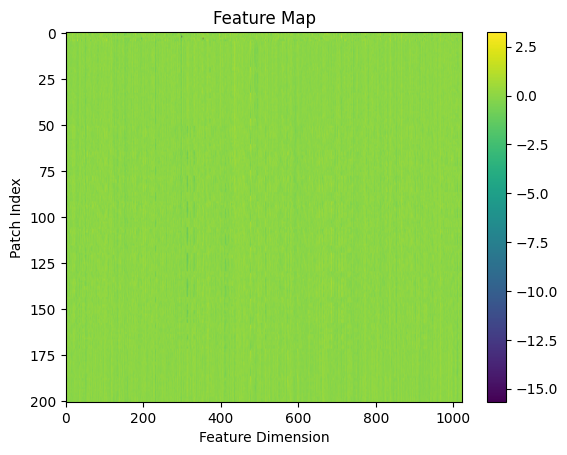

In [6]:
import numpy as np
import matplotlib.pyplot as plt

features = np.load('/home/rl23/Desktop/code/Dinov3FeatureExtration /dinov3/test_feature/features_facebook/dinov3-vitl16-pretrain-lvd1689m.npy')  # shape: (1, 201, 768)
features = features[0]  # 去掉 batch 维度，变成 (201, 768)
print('Feature shape:', features.shape)
plt.imshow(features, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Feature Map')
plt.xlabel('Feature Dimension')
plt.ylabel('Patch Index')
plt.show()

In [4]:
# 假设原图为224x224，patch size=16，则patch数为14x14=196，CLS token在第0位
import math
from PIL import Image
image = Image.open('/home/rl23/Desktop/code/Dinov3FeatureExtration /dinov3/test_feature/pipeline-cat-chonk.jpeg')  # 或用你自己的图片路径
h, w = image.size

num_patches = 14  # ViT-B/16 默认 14x14 patch
patch_features = features[1:197]  # 去掉第0个CLS token，只取patch token
patch_map = patch_features.mean(axis=1).reshape(num_patches, num_patches)  # 每个patch均值
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.imshow(patch_map, cmap='jet', alpha=0.5, extent=(0, w, h, 0))
plt.title('Patch Feature Heatmap Overlay')
plt.axis('off')
plt.show()

ValueError: cannot reshape array of size 0 into shape (14,14)

(192, 256, 256)


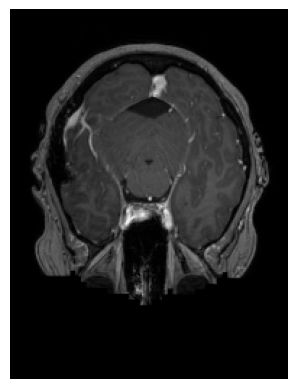

In [2]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
us=sitk.ReadImage('/home/rl23/Desktop/code/Dinov3FeatureExtration /dinov3/test_feature/MRI_image/Case1-T1.nii.gz')
print(us.GetSize())
#slice the image
slice_index = us.GetSize()[2] // 2  # 取中间切
us_slice = us[:, :, slice_index]
us_array = sitk.GetArrayFromImage(us_slice)
plt.imshow(us_array, cmap='gray')
#save as .jpeg
plt.axis('off')
plt.savefig('/home/rl23/Desktop/code/Dinov3FeatureExtration /dinov3/test_feature/MRI_image/Case1-T1.jpeg', bbox_inches='tight', pad_inches=0)

In [1]:
from transformers import pipeline
from transformers.image_utils import load_image
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from transformers import AutoImageProcessor, AutoModel
from transformers.image_utils import load_image


url = "/home/rl23/Desktop/code/Dinov3FeatureExtration /dinov3/test_feature/US_image/Case1-US-before.jpeg"
image = load_image(url)

pretrained_model_name = "facebook/dinov3-vitl16-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
model = AutoModel.from_pretrained(
    pretrained_model_name, 
    device_map="auto", 
)

inputs = processor(images=image, return_tensors="pt").to(model.device)
with torch.inference_mode():
    outputs = model(**inputs)

pooled_output = outputs.pooler_output
print("Pooled output shape:", pooled_output.shape)
model_name = pretrained_model_name
save_path = '/home/rl23/Desktop/code/Dinov3FeatureExtration /dinov3/test_feature/us_features_pool/' + model_name + '.npy'

# 确保父目录存在
os.makedirs(os.path.dirname(save_path), exist_ok=True)

np.save(save_path, pooled_output.cpu().numpy())
print('Features saved to', save_path)

/home/rl23/anaconda3/envs/dino3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 34663.67it/s]


Pooled output shape: torch.Size([1, 1024])
Features saved to /home/rl23/Desktop/code/Dinov3FeatureExtration /dinov3/test_feature/us_features_pool/facebook/dinov3-vitl16-pretrain-lvd1689m.npy


/home/rl23/anaconda3/envs/dino3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[info] 原图尺寸: 277x369


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 28339.89it/s]


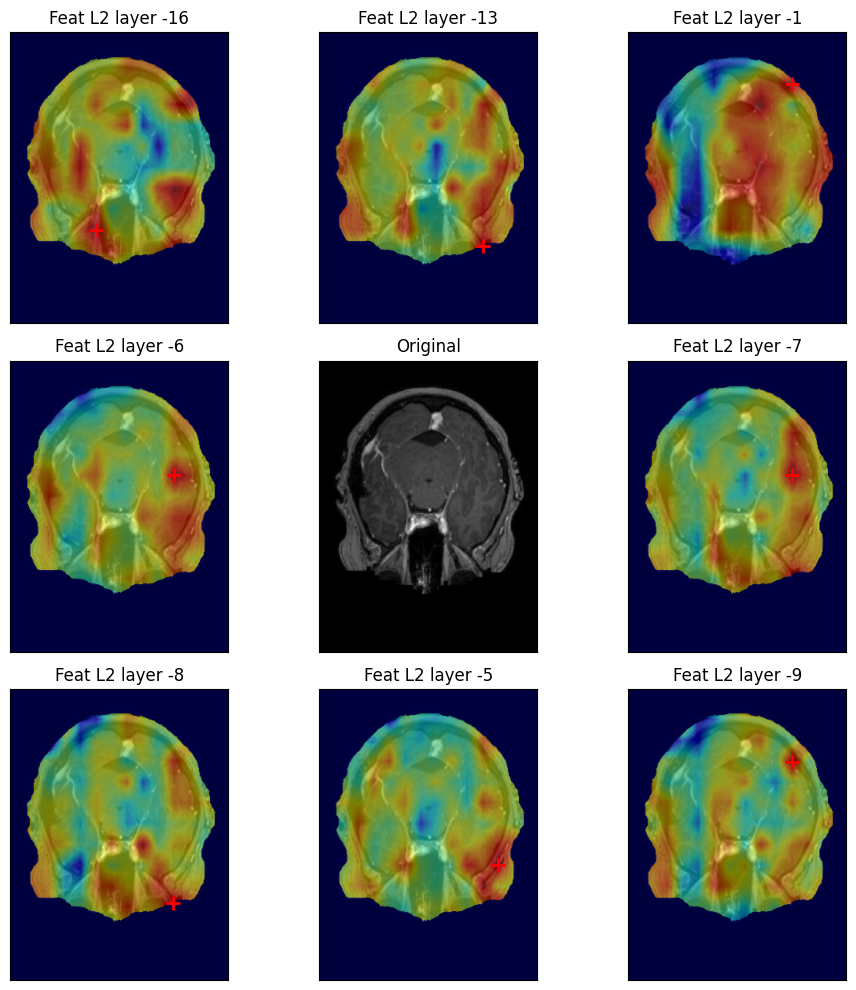

[done] 已保存: encoder_focus_grid_masked_MRI_vitl16.png
[debug] grid=14x14=196, patch=16, mode=feat, maps=8


In [3]:
# -*- coding: utf-8 -*-
"""
US Encoder Focus Grid with Foreground (Fan) Masking

- 支持 DINOv3 ViT-L/16（或其他 ViT/16）
- 自动生成 US 扇形前景掩膜，避免注意力/范数落在黑色背景
- 掩膜内归一化 + 质量评分，挑选前景关注最强的 8 张
- 自动剔除 register tokens
"""

import os
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from transformers import AutoImageProcessor, AutoModel

# ========= 配置 =========
MODEL_NAME = "facebook/dinov3-vitl16-pretrain-lvd1689m"
IMG_PATH = "/home/rl23/Desktop/code/Dinov3FeatureExtration /dinov3/test_feature/MRI_image/Case1-T1.jpeg"
SAVE_PATH = "encoder_focus_grid_masked_MRI_vitl16.png"
NUM_MAPS = 8           # 四周展示多少张（建议 8）
ALPHA = 0.5            # 叠加透明度
METRIC = "mass"        # 选图指标: 'mass' (ROI内积分) 或 'contrast' (ROI vs BG 对比)
USE_ATT_LAST = True    # True: 只看最后一层注意力；False: 会回退到特征范数或多层

# ========= 小工具 =========
def safe_open(path: str) -> Image.Image:
    """修正你路径里的异常空格并读图"""
    try:
        return Image.open(path).convert("RGB")
    except Exception:
        fixed = path.replace("FeatureExtration /", "FeatureExtration/")
        if fixed != path:
            print(f"[info] 修正路径:\n  {path}\n-> {fixed}")
            return Image.open(fixed).convert("RGB")
        raise

def get_patch_size(model) -> int:
    for cfg in [getattr(model.config, "vision_config", None), model.config]:
        if cfg is not None and hasattr(cfg, "patch_size"):
            return int(getattr(cfg, "patch_size"))
    return 16

def normalize01(x: np.ndarray) -> np.ndarray:
    x = x.astype(np.float32)
    mn, mx = float(x.min()), float(x.max())
    if mx - mn < 1e-12:
        return np.zeros_like(x, dtype=np.float32)
    return (x - mn) / (mx - mn)

def upsample(hm_t: torch.Tensor, H0: int, W0: int) -> np.ndarray:
    """hm_t: (Hp, Wp) -> (H0,W0) numpy"""
    hm = hm_t.unsqueeze(0).unsqueeze(0)  # (1,1,Hp,Wp)
    hm = F.interpolate(hm, size=(H0, W0), mode="bilinear", align_corners=False)[0, 0].cpu().numpy()
    return hm

def build_us_fan_mask(img_pil: Image.Image, shrink=0.98) -> np.ndarray:
    """
    基于强度 + 最大连通域 + 形态学闭操作的 US 扇形前景掩膜 (H,W) 0/1
    shrink<1 轻微内缩，避免边界假亮
    """
    img = np.array(img_pil)
    if img.ndim == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img

    # 阈值去背景（自适应，鲁棒）
    thr = max(5, int(np.percentile(gray, 5)))
    mask = (gray > thr).astype(np.uint8)

    # 最大连通域（保留扇形）
    num, lab = cv2.connectedComponents(mask)
    if num > 1:
        areas = [(lab == i).sum() for i in range(1, num)]
        keep = 1 + int(np.argmax(areas))
        mask = (lab == keep).astype(np.uint8)
    else:
        mask = (lab > 0).astype(np.uint8)

    # 闭操作平滑边界、补洞
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21, 21))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k)

    # 轻微内缩
    if shrink < 1.0:
        r = int(max(1, round(min(gray.shape[:2]) * (1 - shrink) * 0.5)))
        if r > 0:
            k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * r + 1, 2 * r + 1))
            mask = cv2.erode(mask, k2, iterations=1)

    return mask.astype(np.uint8)

def maskwise_normalize(hm: np.ndarray, mask: np.ndarray, eps=1e-8) -> np.ndarray:
    """仅在 mask==1 区域归一化，背景置 0"""
    out = np.zeros_like(hm, dtype=np.float32)
    fg = hm[mask == 1]
    if fg.size == 0:
        return out
    mn, mx = float(fg.min()), float(fg.max())
    if mx - mn < eps:
        return out
    out[mask == 1] = (fg - mn) / (mx - mn + eps)
    return out

def score_map(hm: np.ndarray, mask: np.ndarray, metric="mass") -> float:
    """给热力图一个分数，用于选 top-k"""
    area_fg = mask.sum() + 1e-8
    if metric == "mass":
        return float((hm * (mask > 0)).sum() / area_fg)
    # 对比度：前景中位-背景中位，归一到前景STD
    fg = hm[mask == 1]
    bg = hm[mask == 0]
    if fg.size == 0 or bg.size == 0:
        return 0.0
    return float((np.median(fg) - np.median(bg)) / (np.std(fg) + 1e-6))

# ========= 主流程 =========
def main():
    # 读图
    img = safe_open(IMG_PATH)
    W0, H0 = img.size
    print(f"[info] 原图尺寸: {W0}x{H0}")

    # 模型
    processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
    model = AutoModel.from_pretrained(MODEL_NAME)
    model.eval()

    # 前向
    inputs = processor(images=img, return_tensors="pt")
    with torch.no_grad():
        out = model(**inputs, output_attentions=True, output_hidden_states=True)

    # 计算 patch 网格
    _, _, Hs, Ws = inputs["pixel_values"].shape  # (B,C,H',W')
    p = get_patch_size(model)
    Hp, Wp = Hs // p, Ws // p
    num_patch = Hp * Wp

    # 扇形前景掩膜（原图尺寸）
    mask = build_us_fan_mask(img, shrink=0.985)

    heatmaps = []
    titles = []

    # ========== 路径 A：若有 attentions，用 CLS->patch ==========
    if getattr(out, "attentions", None) is not None and out.attentions:
        att = out.attentions[-1] if USE_ATT_LAST else out.attentions[0]  # (B, heads, 1+T_all, 1+T_all)
        B, Hh, Ttok, _ = att.shape
        assert B == 1

        # 只取前 Hp*Wp 个 patch（忽略 register tokens）
        cls2patch = att[:, :, 0, 1:1 + num_patch]  # (1, heads, Hp*Wp)
        # 生成每个 head 的热力图（掩膜内归一化）
        for h in range(cls2patch.shape[1]):
            hm = cls2patch[0, h]  # (Hp*Wp,)
            # 先自身归一化再上采样
            hm = hm / (hm.max() + 1e-8)
            hm = upsample(hm.reshape(Hp, Wp), H0, W0)
            hm = maskwise_normalize(hm, mask)
            heatmaps.append(hm)
            titles.append(f"Attn Head {h}")
        mode = "attn"

    # ========== 路径 B：无 attentions，回退为 patch 特征范数 ==========
    else:
        hs_list = list(out.hidden_states)  # list[层], 每层 (B, 1+T_all, D)
        # 去掉 embedding 层（第 0 层），从后往前挑 NUM_MAPS*2 个候选，再选 top-k
        hs_list = hs_list[1:]
        candidates = []
        for idx, hs in enumerate(hs_list[-(NUM_MAPS * 2):]):
            pt = hs[:, 1:1 + num_patch, :]          # 只取前 Hp*Wp patch
            feat_norm = pt.norm(p=2, dim=-1)[0]     # (Hp*Wp,)
            hm = upsample(feat_norm.reshape(Hp, Wp), H0, W0)
            hm = maskwise_normalize(hm, mask)
            candidates.append((hm, f"Feat L2 layer {-len(hs_list) + (len(hs_list) - (NUM_MAPS * 2) + idx)}"))

        # 评分并选 top-k
        scored = [(score_map(h, mask, METRIC), i) for i, (h, _) in enumerate(candidates)]
        scored.sort(reverse=True, key=lambda x: x[0])
        keep_idx = [i for _, i in scored[:NUM_MAPS]]
        for i in keep_idx:
            heatmaps.append(candidates[i][0])
            titles.append(candidates[i][1])
        mode = "feat"

    # ========== 画 3×3 网格 ==========
    # 若不足 8 张，重复补足
    if len(heatmaps) < NUM_MAPS:
        heatmaps = heatmaps * (NUM_MAPS // max(1, len(heatmaps)) + 1)
        titles = titles * (NUM_MAPS // max(1, len(titles)) + 1)
    heatmaps = heatmaps[:NUM_MAPS]
    titles = titles[:NUM_MAPS]

    fig = plt.figure(figsize=(10, 10))
    pos = [(1,1),(1,2),(1,3),
           (2,1),       (2,3),
           (3,1),(3,2),(3,3)]

    for i, hm in enumerate(heatmaps[:8]):
        r, c = pos[i]
        ax = plt.subplot(3, 3, (r - 1) * 3 + c)
        ax.imshow(img)
        # γ 校正提升亮部（可调 0.6~0.8）
        show_hm = np.power(hm, 0.7)
        ax.imshow(show_hm, cmap="jet", alpha=ALPHA)
        # 标红最大点（只在前景内查找）
        hm_fg = hm.copy()
        hm_fg[mask == 0] = 0
        if hm_fg.max() > 0:
            y, x = np.unravel_index(np.argmax(hm_fg), hm_fg.shape)
            ax.plot([x], [y], marker="+", color="red", markersize=10, markeredgewidth=2)
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(titles[i])

    ax_mid = plt.subplot(3, 3, 5)
    ax_mid.imshow(img); ax_mid.set_xticks([]); ax_mid.set_yticks([])
    ax_mid.set_title("Original")

    plt.tight_layout()
    plt.savefig(SAVE_PATH, dpi=200, bbox_inches="tight")
    plt.show()
    print(f"[done] 已保存: {SAVE_PATH}")
    print(f"[debug] grid={Hp}x{Wp}={num_patch}, patch={p}, mode={mode}, maps={len(heatmaps)}")

if __name__ == "__main__":
    main()
